In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from openai import OpenAI
from key import HF_LLMA3_KEY, GROQ_KEY
from groq import Groq       # https://console.groq.com/docs/models
client = Groq(api_key=GROQ_KEY)

In [2]:
movie_latest_small=pd.read_csv('../../data/processed_movie_latest_small.csv')
movie_latest_small.head()

,userId,movieId,title,genres,rating,timestamp,tag
0,1,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",4.0,964982703,NaN
1,1,3,Grumpier Old Men (1995),"Comedy, Romance",4.0,964981247,NaN
2,1,6,Heat (1995),"Action, Crime, Thriller",4.0,964982224,NaN
3,1,47,Seven (a.k.a. Se7en) (1995),"Mystery, Thriller",5.0,964983815,NaN
4,1,50,"Usual Suspects, The (1995)","Crime, Mystery, Thriller",5.0,964982931,NaN


In [3]:
# for each user, find his top-most rated movies
N_TOP_MOVIES = 10
def get_top_recent_movies(movies_df, user_id, num_movies=N_TOP_MOVIES):
    user_ratings = movies_df[movies_df['userId'] == user_id]
    user_ratings = user_ratings.sort_values(by=['rating', 'timestamp'], ascending=[False, False])
    return user_ratings.head(num_movies)

# get the top 5 movies for all users
top_movies = pd.DataFrame()
for user_id in movie_latest_small['userId'].unique():
    top_movies = pd.concat([top_movies, get_top_recent_movies(movie_latest_small, user_id, 10)])
top_movies.reset_index(drop=True, inplace=True)
top_movies.head(15)

,userId,movieId,title,genres,rating,timestamp,tag
0,1,553,Tombstone (1993),"Action, Drama, Western",5.0,964984153,NaN
1,1,157,Canadian Bacon (1995),"Comedy, War",5.0,964984100,NaN
2,1,1298,Pink Floyd: The Wall (1982),"Drama, Musical",5.0,964984086,NaN
3,1,3053,"Messenger: The Story of Joan of Arc, The (1999)","Drama, War",5.0,964984086,NaN
4,1,3448,"Good Morning, Vietnam (1987)","Comedy, Drama, War",5.0,964984054,NaN
5,1,151,Rob Roy (1995),"Action, Drama, Romance, War",5.0,964984041,NaN
6,1,1224,Henry V (1989),"Action, Drama, Romance, War",5.0,964984018,NaN
7,1,527,Schindler's List (1993),"Drama, War",5.0,964984002,NaN
8,1,5060,M*A*S*H (a.k.a. MASH) (1970),"Comedy, Drama, War",5.0,964984002,NaN
9,1,3147,"Green Mile, The (1999)","Crime, Drama",5.0,964983873,NaN


In [4]:
import re

def extract_movie_titles(response):
    # Extract lines that match the format [Title (Year)]
    pattern = r"\[.*\]"
    titles = re.findall(pattern, response)
    return [title.strip("[]") for title in titles]

In [5]:
""" Number of users to run the recommender on
    (Use a small sample for faster results)
    If you want to run the recommender on all users, uncomment the last line
"""
# num_users = 5

# Uncomment below to run on all users
num_users = len(movie_latest_small['userId'].unique())

print(f"Running the recommender on {num_users} users")

Running the recommender on 610 users


In [6]:
def llma3(prompts, num_users, output_file='responses_basic.json'):

    responses = []
    for i in range(num_users):
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages= [
                {
                     'role':'user',
                     'content' : prompts[i]
                }
            ],
            temperature=0,
            # max_tokens=100,
            # stop=None
        )
    
        if i % 50 == 0:
            print(f"Completed {i} users")
        responses.append(response)

    # parse the responses
    responses_recommendations = [extract_movie_titles(response.choices[0].message.content) for response in responses]

    # write the responses to a file
    with open(output_file, 'w') as f:
        for i in range(num_users):
            f.write(str(responses_recommendations[i]) + '\n')
        
        print(f"Response written to {output_file}")
    return responses_recommendations

# calculate the hit rate
# hit rate for the recommendations
def hit_rate(recommendation, actual):
    hit = 0
    for rec in recommendation:
        if rec in actual:
            hit += 1
    return hit/len(recommendation)

# NDCG for the recommendations
def ndcg(recommendation, actual):
    dcg = 0
    for i, rec in enumerate(recommendation):
        if rec in actual:
            dcg += 1/np.log2(i+2)
    idcg = 0
    for i in range(len(actual)):
        idcg += 1/np.log2(i+2)
    return dcg/idcg


def eval_response(responses_recommendations, selected_movie_data, original_movie_data, num_users):
    hit_rates = []
    ndcg_scores = []
    for i in range(num_users):
        user_id = selected_movie_data['userId'].unique()[i]
        user_movies = original_movie_data[original_movie_data['userId']==user_id]
        user_watched_movies = user_movies['title'].values
        # print(f"User {user_id} watched movies: {user_watched_movies}")
        recommendation = responses_recommendations[i]
        # print(f"Recommendation: {recommendation}")
        hit_rate_ = hit_rate(recommendation, user_watched_movies)
        # print(f"Hit Rate: {hit_rate_}")
        hit_rates.append(hit_rate_)
        ndcg_ = ndcg(recommendation, user_watched_movies)
        # print(f"NDCG: {ndcg_}")
        ndcg_scores.append(ndcg_)

    avg_hit_rate = np.mean(hit_rates)
    avg_ndcg = np.mean(ndcg_scores)

    print(f"Average Hit Rate: {avg_hit_rate}")
    print(f"Average NDCG: {avg_ndcg}")

    return hit_rates, ndcg_scores


In [7]:
# read the responses from the json file
def read_responses(output_file):
    responses_recommendations = []
    with open(output_file, 'r') as f:
        for line in f:
            responses_recommendations.append(eval(line))
    return responses_recommendations

## Basic prompt

In [19]:
def generate_prompt(df, user_id, num):
    df_user = df[df['userId'] == user_id]
    movies_list = '\n'.join([f"Movie {i+1}: {row['title']}, Rating: {row['rating']}" for i, row in df_user.iterrows()])
    
    prompt_template = '''
I am user {user_id}. My most recent {num} top-rated movies are listed below:
{movies_list}
Please recommend 10 movies similar to these that I haven't watched yet. Format your response as a list of movie titles, using brackets around the titles and separating each title with a new line for easy parsing.
Example format:
Here are the 10 movies recommended for you: 
[Midnight Cowboy (1969)]
[Lost in Translation (2003)]
[etc.]

Answer:
    '''

    prompt = prompt_template.format(user_id=user_id, num=num, movies_list=movies_list)
    return prompt

In [20]:
prompts_1 = []
for user_id in top_movies['userId'].unique():
    prompt = generate_prompt(top_movies, user_id, N_TOP_MOVIES)
    prompts_1.append(prompt)

print(prompts_1[0])


I am user 1. My most recent 10 top-rated movies are listed below:
Movie 1: Tombstone (1993), Rating: 5.0
Movie 2: Canadian Bacon (1995), Rating: 5.0
Movie 3: Pink Floyd: The Wall (1982), Rating: 5.0
Movie 4: Messenger: The Story of Joan of Arc, The (1999), Rating: 5.0
Movie 5: Good Morning, Vietnam (1987), Rating: 5.0
Movie 6: Rob Roy (1995), Rating: 5.0
Movie 7: Henry V (1989), Rating: 5.0
Movie 8: Schindler's List (1993), Rating: 5.0
Movie 9: M*A*S*H (a.k.a. MASH) (1970), Rating: 5.0
Movie 10: Green Mile, The (1999), Rating: 5.0
Please recommend 10 movies similar to these that I haven't watched yet. Format your response as a list of movie titles, using brackets around the titles and separating each title with a new line for easy parsing.
Example format:
Here are the 10 movies recommended for you: 
[Midnight Cowboy (1969)]
[Lost in Translation (2003)]
[etc.]

Answer:
    


In [21]:
prompt_1_rec = llma3(prompts_1, num_users, output_file='responses_basic_3.json')

Completed 0 users
Completed 50 users
Completed 100 users
Completed 150 users
Completed 200 users
Completed 250 users
Completed 300 users
Completed 350 users
Completed 400 users
Completed 450 users
Completed 500 users
Completed 550 users
Completed 600 users
Response written to responses_basic_3.json


In [22]:
hit_rates_1, ndcg_scores_1 = eval_response(prompt_1_rec, top_movies, movie_latest_small, num_users)

Average Hit Rate: 0.08852459016393442
Average NDCG: 0.01946583698344318


45min 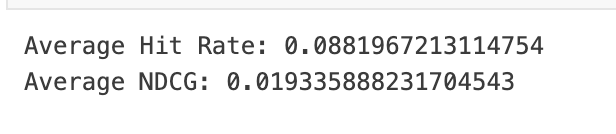

## Basic prompt + Genre

In [16]:
def generate_prompt_genre(df, user_id, num):
    df_user = df[df['userId'] == user_id]
    movies_list = '\n'.join([f"Movie {i+1}: {row['title']}; Genre: {row['genres']}; Rating: {row['rating']}" for i, row in df_user.iterrows()])
    
    prompt_template = '''
I am user {user_id}. My most recent {num} top-rated movies are listed below along with their genres and my ratings.:
{movies_list}
Please recommend 10 movies similar to these that I haven't watched yet. Format your response as a list of movie titles, using brackets around the titles and separating each title with a new line for easy parsing.
Example format:
Here are the 10 movies recommended for you: 
[Midnight Cowboy (1969)]
[Lost in Translation (2003)]
[etc.]

Answer:
    '''

    prompt = prompt_template.format(user_id=user_id, num=num, movies_list=movies_list)
    return prompt

In [17]:
prompts_genre = []
for user_id in top_movies['userId'].unique():
    prompt_genre = generate_prompt_genre(top_movies, user_id, N_TOP_MOVIES)
    prompts_genre.append(prompt_genre)

print(prompts_genre[0])


I am user 1. My most recent 10 top-rated movies are listed below along with their genres and my ratings.:
Movie 1: Tombstone (1993); Genre: Action, Drama, Western; Rating: 5.0
Movie 2: Canadian Bacon (1995); Genre: Comedy, War; Rating: 5.0
Movie 3: Pink Floyd: The Wall (1982); Genre: Drama, Musical; Rating: 5.0
Movie 4: Messenger: The Story of Joan of Arc, The (1999); Genre: Drama, War; Rating: 5.0
Movie 5: Good Morning, Vietnam (1987); Genre: Comedy, Drama, War; Rating: 5.0
Movie 6: Rob Roy (1995); Genre: Action, Drama, Romance, War; Rating: 5.0
Movie 7: Henry V (1989); Genre: Action, Drama, Romance, War; Rating: 5.0
Movie 8: Schindler's List (1993); Genre: Drama, War; Rating: 5.0
Movie 9: M*A*S*H (a.k.a. MASH) (1970); Genre: Comedy, Drama, War; Rating: 5.0
Movie 10: Green Mile, The (1999); Genre: Crime, Drama; Rating: 5.0
Please recommend 10 movies similar to these that I haven't watched yet. Format your response as a list of movie titles, using brackets around the titles and separa

In [18]:
prompt_genre_rec = llma3(prompts_genre, num_users, output_file='responses_genre_3.json')

Completed 0 users
Completed 50 users
Completed 100 users
Completed 150 users
Completed 200 users
Completed 250 users
Completed 300 users
Completed 350 users
Completed 400 users
Completed 450 users
Completed 500 users
Completed 550 users
Completed 600 users
Response written to responses_genre_3.json


In [19]:
hit_rates_genre, ndcg_scores_genre = eval_response(prompt_genre_rec, top_movies, movie_latest_small, num_users)

Average Hit Rate: 0.07998509687034278
Average NDCG: 0.017045888423156873
